In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer as scaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, make_scorer,confusion_matrix, ConfusionMatrixDisplay

#experimental
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import time
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
# Load the data into DataFrames
df = pd.read_csv('sales.csv')

In [5]:
# Clean the data
df = df.dropna()


In [6]:
# Drop the individual ID column
df = df.drop('INDIVIDUALID', axis=1)


In [7]:
# encode the data with pandas get_dummies
df = pd.get_dummies(df, columns=['GENDER', 'AGECODE', 'MARITALSTATUS', 'INCOME', 'LOCATIONTYPE', 'HOMEVALUE', 'MARITALSTATUS', 'EXPENDABLEINCOMERANK'], dtype=int)
df['SOLD'] = df['SOLD'].apply(lambda x: 0 if x == 0 else 1)
# Split the data into smaller development set and larger analysis set 
df_dev, df_analysis = train_test_split(df, test_size=0.99, random_state=42)



In [8]:
# Split the data into features and target
X = df_dev.drop('SOLD', axis=1)
y = df_dev['SOLD']



# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train.value_counts()

SOLD
0    2930
1     339
Name: count, dtype: int64

RandomForestClassifier()
0.6


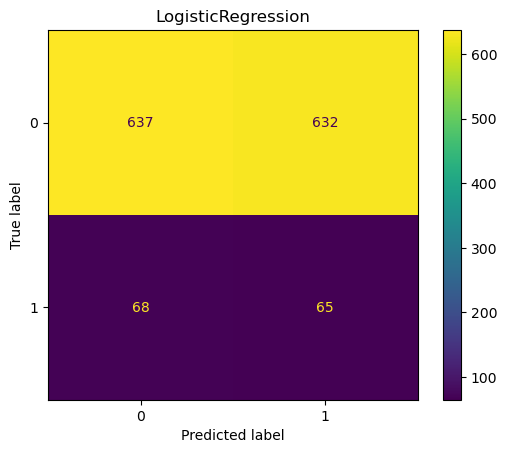

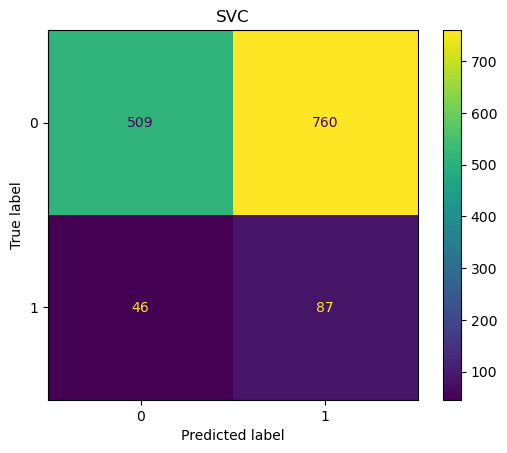

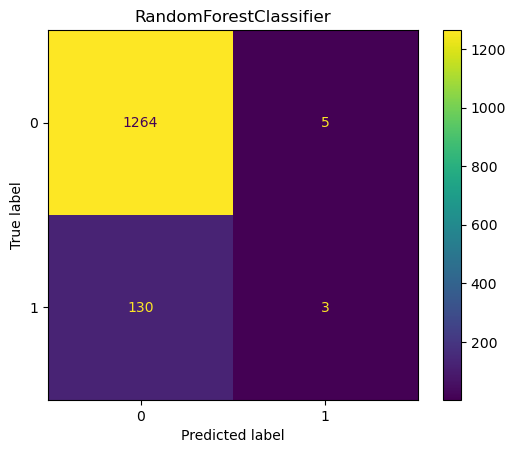

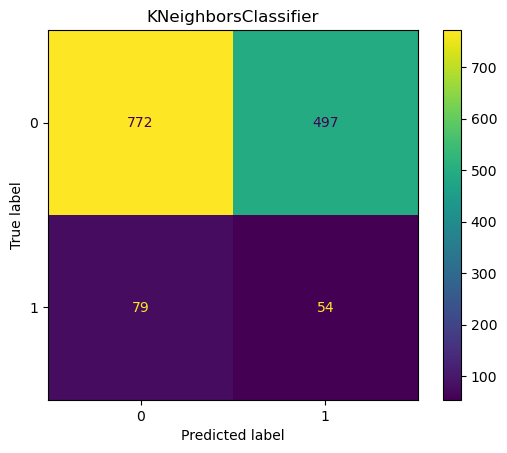

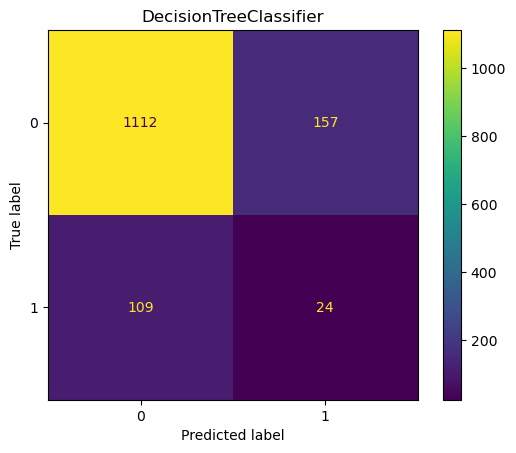

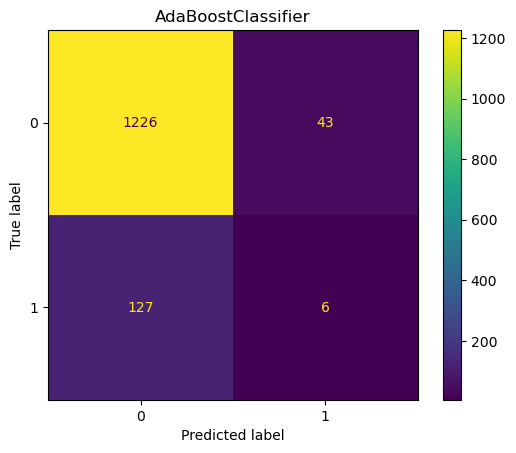

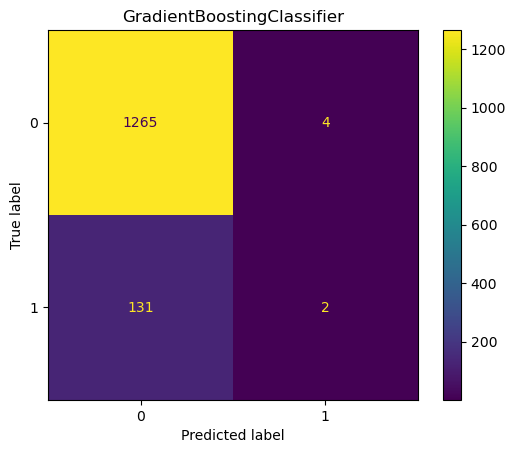

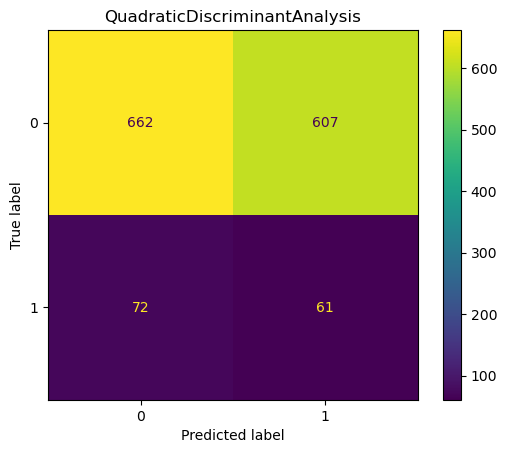

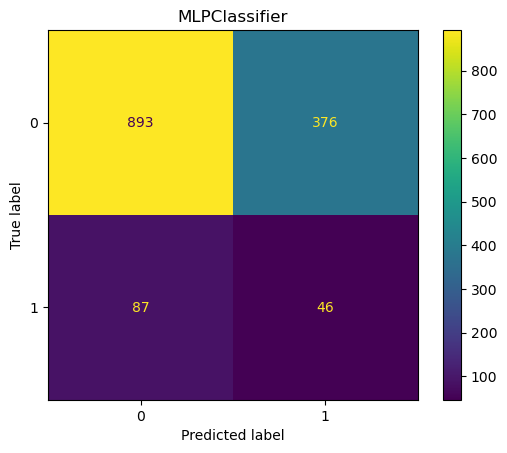

In [9]:
# create a pipeline to scale the data and test several different kinds of classifiers

models = [LogisticRegression(), SVC(), RandomForestClassifier(), KNeighborsClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(), QuadraticDiscriminantAnalysis(), MLPClassifier()]

bestModelRatio = 0 
bestModel = None

for model in models:
    pipeline = Pipeline([
        ('scaler', scaler()),
        ('sampler', SMOTE()),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    predict = pipeline.predict(X_test)
    matrix = confusion_matrix(y_test, predict)
    plot = ConfusionMatrixDisplay(matrix).plot()
    plot.ax_.set_title(model.__class__.__name__)



    truePositive = matrix[1][1]
    falsePositive = matrix[0][1]
    trueFalsePositiveRatio = truePositive / falsePositive

    if bestModelRatio < truePositive / falsePositive:
        bestModelRatio = trueFalsePositiveRatio
        bestModel = model
        bestModelPipeline = pipeline

print(bestModel)
print(bestModelRatio)

In [10]:
#Inconclusive results, need to GRIDSEARCHCV to find the best hyperparameters for each model with a custom scoring function. Custom scoring is necessary to deal with the number of predictions being 0

def recallPrecision(ground_truth, predictions):
    recall = recall_score(ground_truth, predictions)
    if recall == 0:
        recall = 0.0001
    elif recall == 1:
        recall = 0.9999
    return recall

scorer = make_scorer(recallPrecision, greater_is_better=True)


Text(0.5, 1.0, 'LogisticRegression')

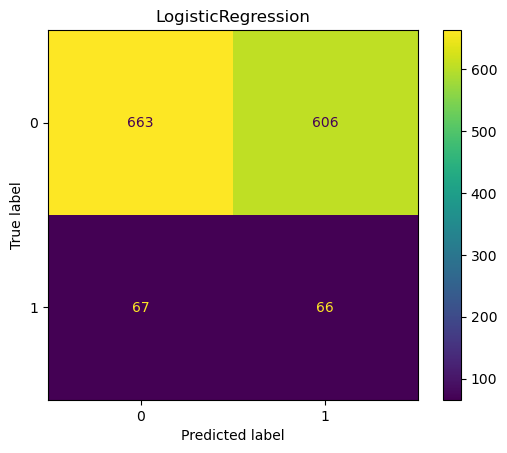

In [11]:

# Logistic Regression
param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}
pipeline = Pipeline([
        ('scaler', scaler()),
        ('sampler', SMOTE()),
        ('model', LogisticRegression())
    ])
log_grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)
log_grid.fit(X_train, y_train)

log_grid_estimator = log_grid.best_estimator_
log_grid_predict = log_grid_estimator.predict(X_test)
log_grid_score = accuracy_score(y_test, log_grid_predict)
matrix = confusion_matrix(y_test, log_grid_predict)
plot = ConfusionMatrixDisplay(matrix).plot()
plot.ax_.set_title(log_grid_estimator['model'].__class__.__name__)


Text(0.5, 1.0, 'SVC')

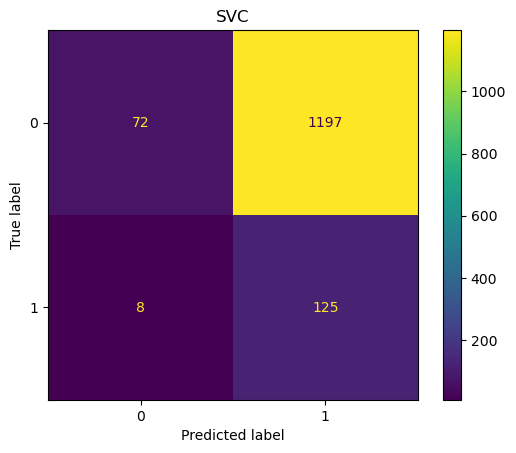

In [12]:
# Support Vector Classifier

param_grid = {'model__gamma':[1,0.1,0.001,0.0001], 'model__kernel':['linear','rbf', 'poly', 'sigmoid']}

pipeline = Pipeline([
        ('scaler', scaler()),
        ('sampler', SMOTE()),
        ('model', SVC())
    ])
svc_grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)
svc_grid.fit(X_train, y_train)

svc_estimator = svc_grid.best_estimator_
svc_estimator_predict = svc_estimator.predict(X_test)
svc_estimator_score = accuracy_score(y_test, svc_estimator_predict)
matrix = confusion_matrix(y_test, svc_estimator_predict)
plot = ConfusionMatrixDisplay(matrix).plot()
plot.ax_.set_title(svc_estimator['model'].__class__.__name__)

Text(0.5, 1.0, 'RandomForestClassifier')

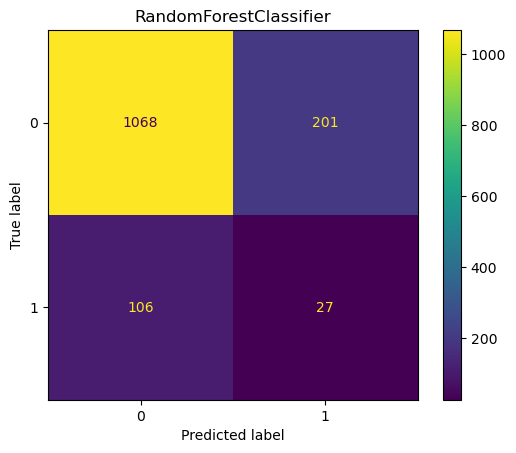

In [13]:
# Random Forest Classifier
param_grid = {'model__max_depth':[3,5,10,None],
            'model__n_estimators':[10,100,200],
            'model__max_features':["sqrt", "log2", None],
            'model__criterion':['gini', 'entropy']
            }
pipeline = Pipeline([
        ('scaler', scaler()),
        ('sampler', SMOTE()),
        ('model', RandomForestClassifier())
    ])
rfc_grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)
rfc_grid.fit(X_train, y_train)

rfc_estimator = rfc_grid.best_estimator_
rfc_estimator_predict = rfc_estimator.predict(X_test)
rfc_estimator_score = accuracy_score(y_test, rfc_estimator_predict)
matrix = confusion_matrix(y_test, rfc_estimator_predict)
plot = ConfusionMatrixDisplay(matrix).plot()
plot.ax_.set_title(rfc_estimator['model'].__class__.__name__)

Text(0.5, 1.0, 'KNeighborsClassifier')

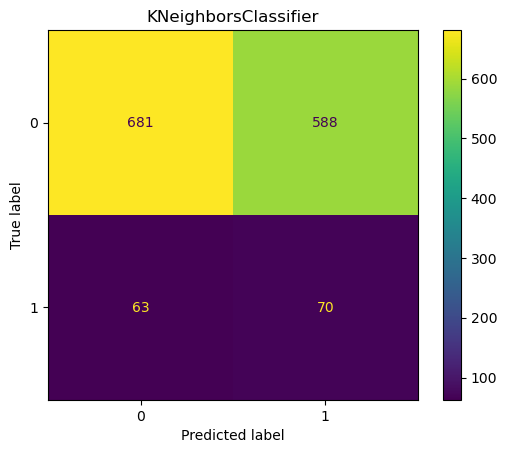

In [14]:
# K Nearest Neighbors
param_grid = {'model__n_neighbors': np.arange(1, 11),
              'model__weights': ['uniform', 'distance'],
              'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'model__p': [1, 2]}
pipeline = Pipeline([
        ('scaler', scaler()),
        ('sampler', SMOTE()),
        ('model', KNeighborsClassifier())
    ])
knn_grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)
knn_grid.fit(X_train, y_train)

knn_estimator = knn_grid.best_estimator_
knn_estimator_predict = knn_estimator.predict(X_test)
knn_estimator_score = accuracy_score(y_test, knn_estimator_predict)
matrix = confusion_matrix(y_test, knn_estimator_predict)
plot = ConfusionMatrixDisplay(matrix).plot()
plot.ax_.set_title(knn_estimator['model'].__class__.__name__)

Text(0.5, 1.0, 'DecisionTreeClassifier')

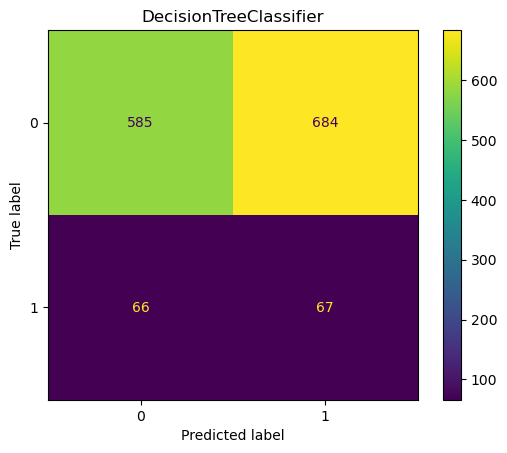

In [15]:
# Decision Tree
param_grid = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [None, 5, 10, 20],
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__max_leaf_nodes': [None, 5, 10, 20]
}
pipeline = Pipeline([
        ('scaler', scaler()),
        ('sampler', SMOTE()),
        ('model', DecisionTreeClassifier())
    ])
dtc_grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)
dtc_grid.fit(X_train, y_train)

dtc_estimator = dtc_grid.best_estimator_
dtc_estimator_predict = dtc_estimator.predict(X_test)
dtc_estimator_score = accuracy_score(y_test, dtc_estimator_predict)
matrix = confusion_matrix(y_test, dtc_estimator_predict)
plot = ConfusionMatrixDisplay(matrix).plot()
plot.ax_.set_title(dtc_estimator['model'].__class__.__name__)


Text(0.5, 1.0, 'QuadraticDiscriminantAnalysis')

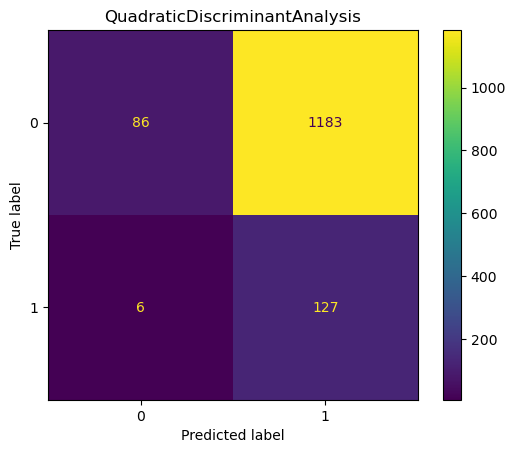

In [16]:
# Quadratic Discriminant Analysis
param_grid = {
    'model__reg_param': [0, 0.1, 0.5, 1],
    'model__tol': [0.0001, 0.001, 0.01, 0.1]
}
pipeline = Pipeline([
        ('scaler', scaler()),
        ('sampler', SMOTE()),
        ('model', QuadraticDiscriminantAnalysis())
    ])
quad_grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)
quad_grid.fit(X_train, y_train)

quad_estimator = quad_grid.best_estimator_
quad_estimator_predict = quad_estimator.predict(X_test)

matrix = confusion_matrix(y_test, quad_estimator_predict)
plot = ConfusionMatrixDisplay(matrix).plot()
plot.ax_.set_title(quad_estimator['model'].__class__.__name__)

Text(0.5, 1.0, 'AdaBoostClassifier')

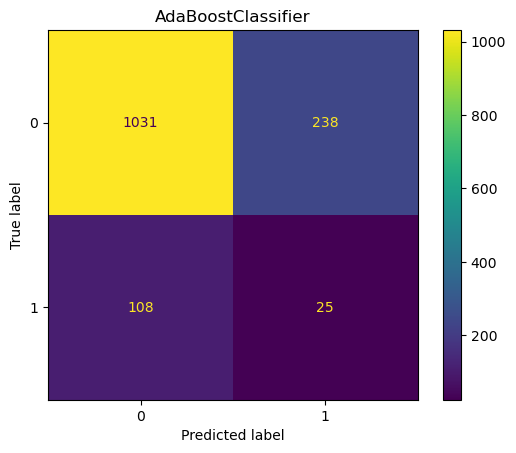

In [17]:
#ADABoost Classifier Analysis
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 1]
}
pipeline = Pipeline([
        ('scaler', scaler()),
        ('sampler', SMOTE()),
        ('model', AdaBoostClassifier())
    ])
ada_grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)
ada_grid.fit(X_train, y_train)
ada_estimator = ada_grid.best_estimator_
ada_estimator_predict = ada_estimator.predict(X_test)
matrix = confusion_matrix(y_test, ada_estimator_predict)
plot = ConfusionMatrixDisplay(matrix).plot()
plot.ax_.set_title(ada_estimator['model'].__class__.__name__)


Text(0.5, 1.0, 'GradientBoostingClassifier')

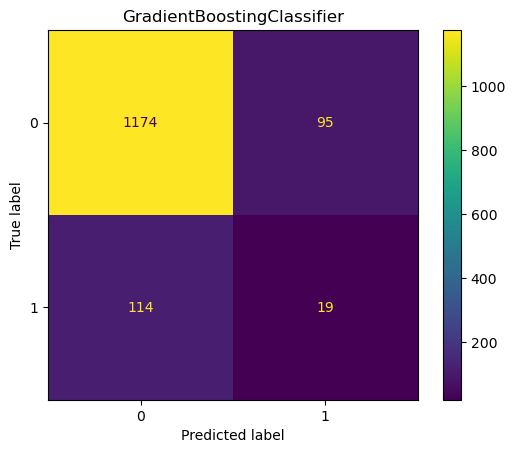

In [18]:
#Gradient Boosting Classifier
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 1],
    'model__max_depth': [3, 5, 10]
}
pipeline = Pipeline([
        ('scaler', scaler()),
        ('sampler', SMOTE()),
        ('model', GradientBoostingClassifier())
    ])
grad_grid = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)
grad_grid.fit(X_train, y_train)
grad_estimator = grad_grid.best_estimator_
grad_estimator_predict = grad_estimator.predict(X_test)
matrix = confusion_matrix(y_test, grad_estimator_predict)
plot = ConfusionMatrixDisplay(matrix).plot()
plot.ax_.set_title(grad_estimator['model'].__class__.__name__)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END model__activation=logistic, model__alpha=0.0001, model__hidden_layer_sizes=(100,), model__solver=adam;, score=0.397 total time=   3.0s
[CV 2/5] END model__activation=logistic, model__alpha=0.0001, model__hidden_layer_sizes=(100,), model__solver=adam;, score=0.324 total time=   3.0s
[CV 3/5] END model__activation=logistic, model__alpha=0.0001, model__hidden_layer_sizes=(100,), model__solver=adam;, score=0.397 total time=   2.9s
[CV 4/5] END model__activation=logistic, model__alpha=0.0001, model__hidden_layer_sizes=(100,), model__solver=adam;, score=0.588 total time=   2.9s
[CV 5/5] END model__activation=logistic, model__alpha=0.0001, model__hidden_layer_sizes=(100,), model__solver=adam;, score=0.463 total time=   2.9s
[CV 1/5] END model__activation=logistic, model__alpha=0.0001, model__hidden_layer_sizes=(100,), model__solver=sgd;, score=0.000 total time=   0.1s
[CV 2/5] END model__activation=logistic, model__alp

Text(0.5, 1.0, 'MLPClassifier')

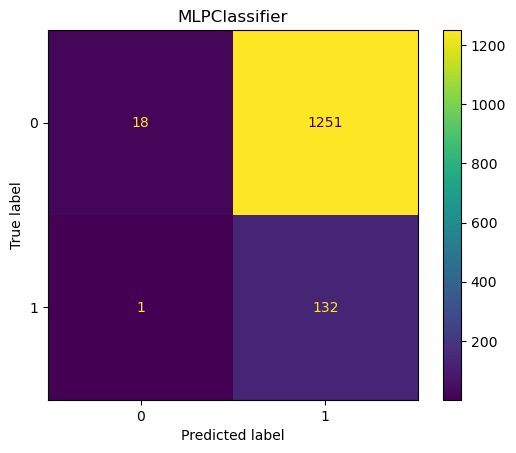

In [19]:
#MLP Classifier
param_grid = {
    'model__hidden_layer_sizes': [(100,), (50, 50), (100, 100)],
    'model__activation': ['logistic', 'tanh', 'relu'],
    'model__solver': ['adam', 'sgd'],
    'model__alpha': [0.0001, 0.001, 0.01]
}
pipeline = Pipeline([
        ('scaler', scaler()),
        ('sampler', SMOTE()),
        ('model', MLPClassifier())
    ])

mlp_grid = GridSearchCV(pipeline, param_grid, cv=5, verbose=3, scoring=scorer)
mlp_grid.fit(X_train, y_train)
mlp_estimator = mlp_grid.best_estimator_
mlp_estimator_predict = mlp_estimator.predict(X_test)
matrix = confusion_matrix(y_test, mlp_estimator_predict)
plot = ConfusionMatrixDisplay(matrix).plot()
plot.ax_.set_title(mlp_estimator['model'].__class__.__name__)

Pipeline(steps=[('scaler', Normalizer()), ('sampler', SMOTE()),
                ('model',
                 GradientBoostingClassifier(learning_rate=1, max_depth=5,
                                            n_estimators=50))])
0.13791439795988697


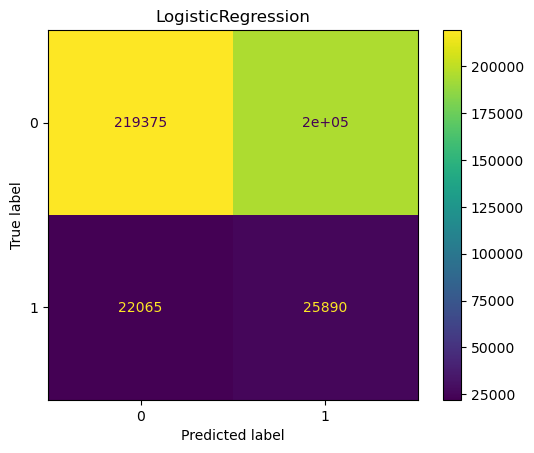

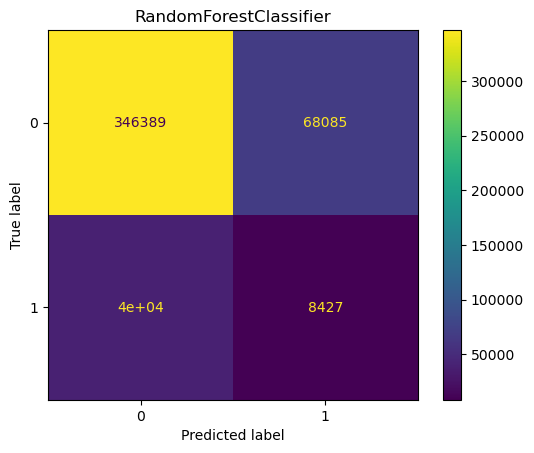

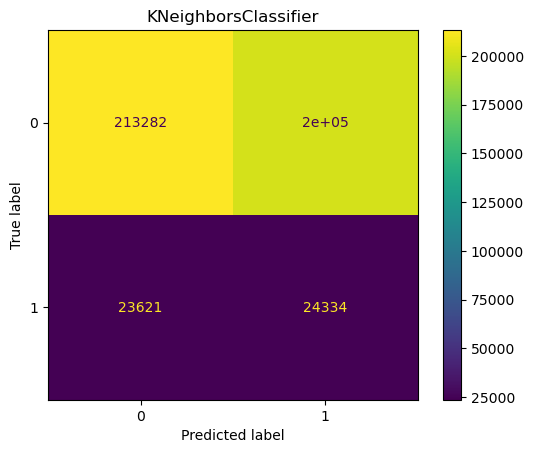

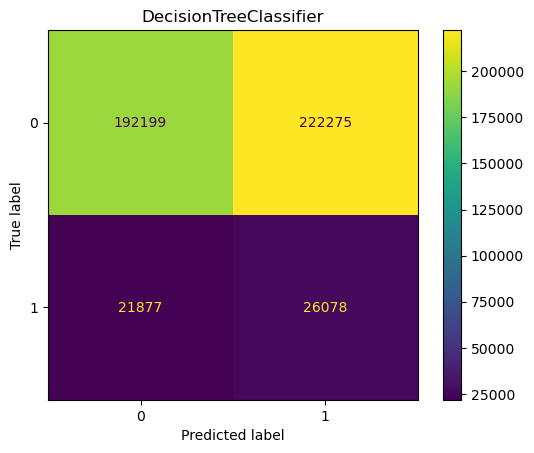

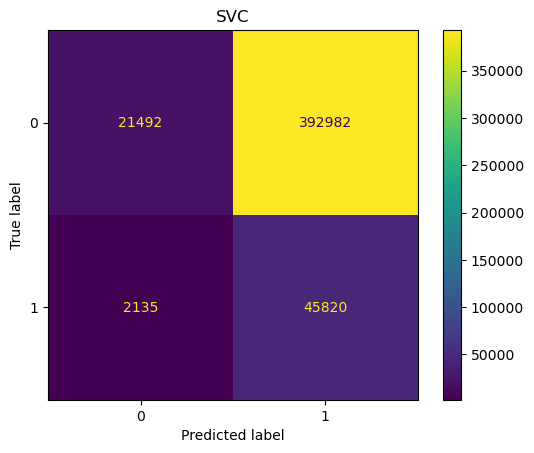

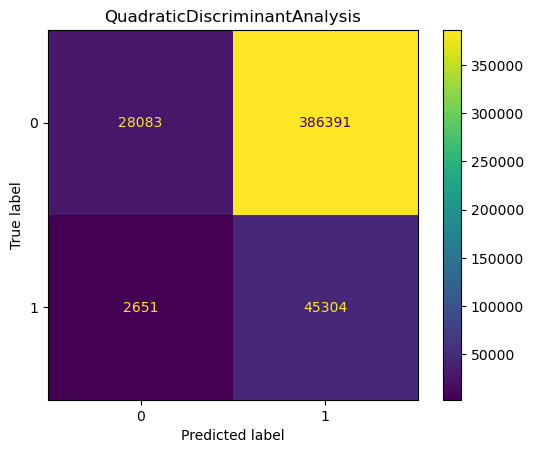

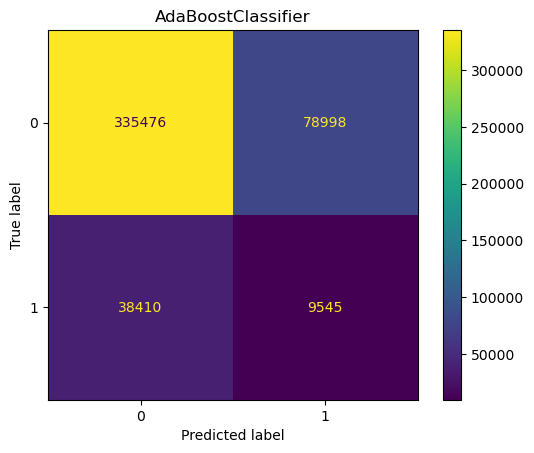

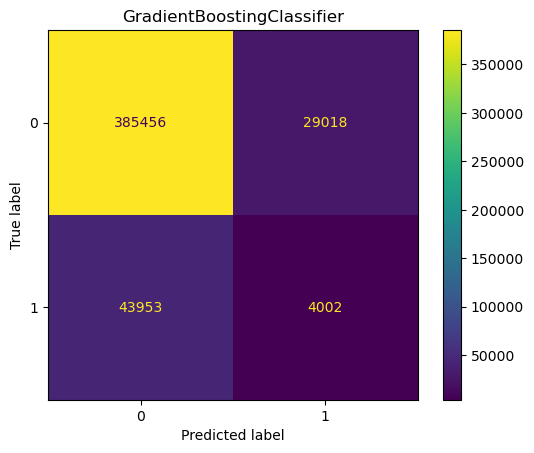

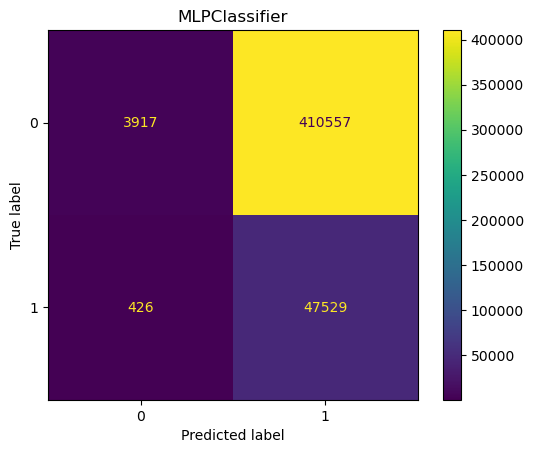

In [20]:
#Split the df_analysis into features and target
X_analysis = df_analysis.drop('SOLD', axis=1)
y_analysis = df_analysis['SOLD']

models = [
    log_grid_estimator,
    rfc_estimator,
    knn_estimator,
    dtc_estimator,
    svc_estimator,
    quad_estimator,
    ada_estimator,
    grad_estimator,
    mlp_estimator
    ]

bestModelRatio = 0 
bestModel = None
bestPlot = None

results_list = []

for model in models: # iterate through the models and predict the results
    predict = model.predict(X_analysis)
    matrix = confusion_matrix(y_analysis, predict)
    plot = ConfusionMatrixDisplay(matrix).plot()
    plot.ax_.set_title(model['model'].__class__.__name__)
    
    truePositive = matrix[1][1]
    falsePositive = matrix[0][1]
    trueFalsePositiveRatio = truePositive / falsePositive

    if bestModelRatio < truePositive / falsePositive: # if the ratio is better than the previous best, update the best model
        bestModelRatio = trueFalsePositiveRatio
        bestModel = model
        bestModelPipeline = pipeline
        bestPlot = plot
        plt.savefig('bestModel.png')
    
    results_list.append({        
        "Model": model['model'].__class__.__name__,
        "Ratio": trueFalsePositiveRatio
        })

results_df = pd.DataFrame.from_dict(results_list)

print(bestModel)
print(bestModelRatio)



                    Model     Ratio
0      LogisticRegression  0.132702
1  RandomForestClassifier  0.123772
2    KNeighborsClassifier  0.120949
3  DecisionTreeClassifier  0.117323
4                     SVC  0.116596


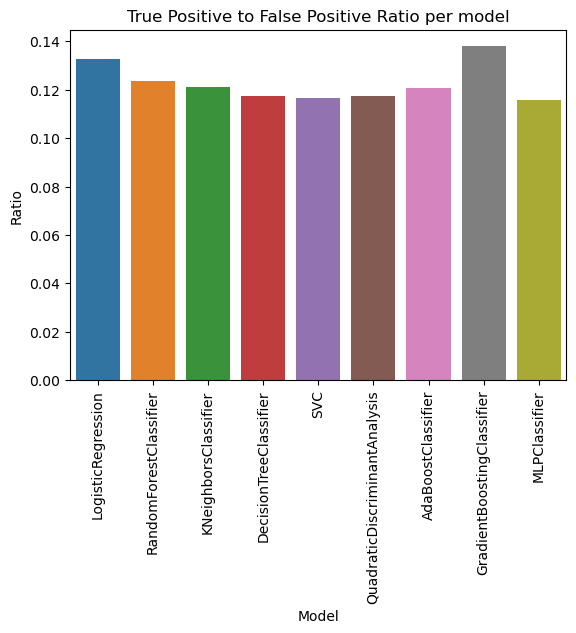

In [21]:
# Plot the results dataframe with seaborn
import seaborn as sns
print(results_df.head())
fig = sns.barplot(x='Model', y='Ratio', data=results_df)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig.set_title('True Positive to False Positive Ratio per model')
fig.figure.savefig('model_results.png')
plt.subplots_adjust(bottom=0.15)
